
<a id='0'></a>

# Rainfall prediction problem 


## 1. The problem statement <a class="anchor" id="1"></a>

In this kernel, we try to answer the question that whether or not it will rain tomorrow in Australia. We implement different models and analyse which would suit best.

Data Sources: http://www.bom.gov.au/climate/data/

Definitions of the Features: http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml




## 2. Import libraries <a class="anchor" id="2"></a>


In [338]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

In [339]:
import warnings

warnings.filterwarnings('ignore')

## 3. Import dataset <a class="anchor" id="3"></a>


In [340]:
df = pd.read_csv("weatherAUS_untill_feb.csv")

## 4. Exploratory data analysis <a class="anchor" id="4"></a>


### View dimensions of dataset <a class="anchor" id="4.1"></a>

In [341]:
df.shape

(191431, 24)

We can see that there are 191431 instances and 24 variables in the data set.

### Preview the dataset <a class="anchor" id="4.2"></a>

In [342]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


### View column names <a class="anchor" id="4.3"></a>

In [343]:
col_names = df.columns

col_names

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [344]:
df.drop(['RISK_MM'], axis=1, inplace=True)

### View summary of dataset <a class="anchor" id="4.5"></a>

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191431 entries, 0 to 191430
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           191431 non-null  object 
 1   Location       191431 non-null  object 
 2   MinTemp        188671 non-null  float64
 3   MaxTemp        188876 non-null  float64
 4   Rainfall       186394 non-null  float64
 5   Evaporation    94845 non-null   float64
 6   Sunshine       86442 non-null   float64
 7   WindGustDir    176954 non-null  object 
 8   WindGustSpeed  177055 non-null  float64
 9   WindDir9am     176693 non-null  object 
 10  WindDir3pm     183702 non-null  object 
 11  WindSpeed9am   188080 non-null  float64
 12  WindSpeed3pm   185025 non-null  float64
 13  Humidity9am    187603 non-null  float64
 14  Humidity3pm    183959 non-null  float64
 15  Pressure9am    170333 non-null  float64
 16  Pressure3pm    170342 non-null  float64
 17  Cloud9am       111072 non-nul

#### Comment

- We can see that the dataset contains mixture of categorical and numerical variables.

- Categorical variables have data type `object`.

- Numerical variables have data type `float64`.

- Also, there are some missing values in the dataset.

### View statistical properties of dataset <a class="anchor" id="4.6"></a>

In [346]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,188671.000000,188876.000000,186394.000000,94845.000000,86442.000000,177055.000000,188080.000000,185025.000000,187603.000000,183959.000000,170333.000000,170342.000000,111072.000000,105192.000000,188599.000000,184959.000000
mean,12.098929,23.288598,2.254155,5.541163,7.653487,40.181221,14.070794,18.695814,68.404482,50.890503,1017.760529,1015.335709,4.568406,4.575823,16.966511,21.753657
std,6.445547,7.168154,8.346685,4.265022,3.768229,13.601082,8.912684,8.769461,19.523763,21.066253,7.066138,7.017521,2.896050,2.748794,6.549200,7.011711
min,-8.700000,-4.100000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,979.100000,978.900000,0.000000,0.000000,-6.200000,-5.100000
25%,7.500000,18.000000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,56.000000,35.000000,1013.000000,1010.500000,1.000000,2.000000,12.200000,16.600000
50%,11.900000,22.700000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,69.000000,51.000000,1017.700000,1015.300000,5.000000,5.000000,16.700000,21.200000
75%,16.800000,28.300000,0.600000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,65.000000,1022.600000,1020.200000,7.000000,7.000000,21.600000,26.500000
max,33.900000,48.900000,474.000000,138.700000,14.500000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.100000,1040.100000,9.000000,9.000000,40.200000,48.200000


### Explore `RainTomorrow` target variable <a class="anchor" id="5.1"></a>

#### Check for missing values

In [347]:
df['RainTomorrow'].isnull().sum()

5038

In [348]:
df['RainToday'].isnull().sum()

5037

There are missing values in the `RainTomorrow` target variable and feature: RainToday. Both these are extremely crucial information for the model. Since they constitute very little of the total set, they can be eliminated instead of risking a statistically approximate imputation.

In [349]:
df = df.dropna(subset= ['RainTomorrow','RainToday'])

#### View number of unique values

In [350]:
df['RainTomorrow'].nunique()

2

The number of unique values in `RainTomorrow` variable is 2.

#### View the unique values

In [351]:
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

The two unique values are `No` and `Yes`.

#### View the frequency distribution of values

In [352]:
df['RainTomorrow'].value_counts()

No     145106
Yes     39467
Name: RainTomorrow, dtype: int64

#### View percentage of frequency distribution of values

In [353]:
df['RainTomorrow'].value_counts()/len(df)

No     0.786171
Yes    0.213829
Name: RainTomorrow, dtype: float64

#### Comment

The total number of `RainTomorrow` values, `No` appears 78.61% times and `Yes` appears 21.13% times.

#### Visualize frequency distribution of `RainTomorrow` variable

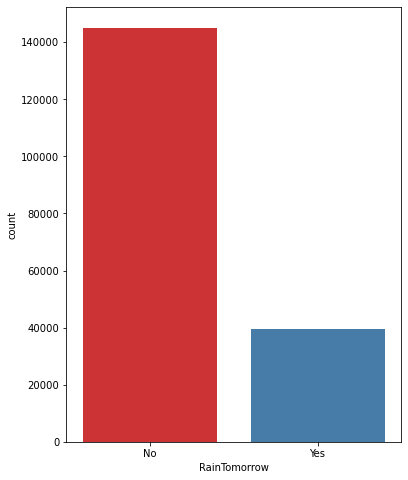

In [354]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=df, palette="Set1")
plt.show()

#### Interpretation

- The above plot confirms our findings that -

   - The `No` variable have 145106 entries, and
   
   - The `Yes` variable have 39467 entries.



### Types of variables <a class="anchor" id="6.1"></a>


Segregating the dataset into categorical and numerical variables. There are a mixture of categorical and numerical variables in the dataset. Categorical variables have data type object. Numerical variables have data type float64.

### Explore Categorical Variables <a class="anchor" id="6.2"></a>

In [355]:
# find categorical variables

categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :', categorical)

There are 7 categorical variables

The categorical variables are : ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [356]:
# view the categorical variables

df[categorical].head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No


### Summary of categorical variables <a class="anchor" id="6.3"></a>


- There is a date variable. It is denoted by `Date` column.


- There are 6 categorical variables. These are given by `Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday` and  `RainTomorrow`.


- There are two binary categorical variables - `RainToday` and  `RainTomorrow`.


- `RainTomorrow` is the target variable.

### Explore problems within categorical variables <a class="anchor" id="6.4"></a>




#### Missing values in categorical variables

In [357]:
# check missing values in categorical variables

df[categorical].isnull().sum()

Date                0
Location            0
WindGustDir     12662
WindDir9am      13549
WindDir3pm       6941
RainToday           0
RainTomorrow        0
dtype: int64

In [358]:
# print categorical variables containing missing values

cat1 = [var for var in categorical if df[var].isnull().sum()!=0]

print(df[cat1].isnull().sum())

WindGustDir    12662
WindDir9am     13549
WindDir3pm      6941
dtype: int64


We can see that there are only 3 categorical variables in the dataset which contains missing values. These are `WindGustDir`, `WindDir9am`, `WindDir3pm`.

#### Frequency count of categorical variables

In [359]:
# view frequency of categorical variables

for var in categorical: 
    
    print(df[var].value_counts())

2013-03-07    49
2014-06-23    49
2017-06-10    49
2019-02-21    49
2013-10-17    49
              ..
2007-12-14     1
2008-01-08     1
2008-01-09     1
2007-12-11     1
2007-11-23     1
Name: Date, Length: 4380, dtype: int64
Canberra            4344
Sydney              4261
Darwin              4135
Perth               4126
Hobart              4107
Brisbane            4016
Townsville          3965
Launceston          3958
Bendigo             3954
MelbourneAirport    3953
PerthAirport        3952
SydneyAirport       3945
Ballarat            3942
Mildura             3942
Nuriootpa           3936
MountGambier        3932
Albury              3931
Sale                3931
AliceSprings        3928
Cobar               3926
Watsonia            3923
Portland            3913
Woomera             3904
Tuggeranong         3903
CoffsHarbour        3883
Albany              3883
Wollongong          3856
Dartmoor            3855
Penrith             3850
Richmond            3848
NorfolkIsland       3839

In [360]:
# view frequency distribution of categorical variables

for var in categorical: 
    
    print(df[var].value_counts()/np.float(len(df)))

2013-03-07    0.000265
2014-06-23    0.000265
2017-06-10    0.000265
2019-02-21    0.000265
2013-10-17    0.000265
                ...   
2007-12-14    0.000005
2008-01-08    0.000005
2008-01-09    0.000005
2007-12-11    0.000005
2007-11-23    0.000005
Name: Date, Length: 4380, dtype: float64
Canberra            0.023535
Sydney              0.023086
Darwin              0.022403
Perth               0.022354
Hobart              0.022251
Brisbane            0.021758
Townsville          0.021482
Launceston          0.021444
Bendigo             0.021422
MelbourneAirport    0.021417
PerthAirport        0.021412
SydneyAirport       0.021374
Ballarat            0.021357
Mildura             0.021357
Nuriootpa           0.021325
MountGambier        0.021303
Albury              0.021298
Sale                0.021298
AliceSprings        0.021282
Cobar               0.021271
Watsonia            0.021254
Portland            0.021200
Woomera             0.021152
Tuggeranong         0.021146
CoffsHarbo

#### Number of labels: cardinality


The number of labels within a categorical variable is known as **cardinality**. A high number of labels within a variable is known as **high cardinality**. High cardinality may pose some serious problems in the machine learning model.

In [361]:
# check for cardinality in categorical variables

for var in categorical:
    
    print(var, ' contains ', len(df[var].unique()), ' labels')

Date  contains  4380  labels
Location  contains  49  labels
WindGustDir  contains  17  labels
WindDir9am  contains  17  labels
WindDir3pm  contains  17  labels
RainToday  contains  2  labels
RainTomorrow  contains  2  labels


Date Variable needs preprocessing

#### Feature Engineering of Date Variable

In [362]:
df['Date'].dtypes

dtype('O')

Parsing the date into datetime format.

In [363]:
# parse the dates, currently coded as strings, into datetime format

df['Date'] = pd.to_datetime(df['Date'])

In [364]:
# extract year from date

df['Year'] = df['Date'].dt.year

df['Year'].head()

0    2008
1    2008
2    2008
3    2008
4    2008
Name: Year, dtype: int64

In [365]:
# extract month from date

df['Month'] = df['Date'].dt.month

df['Month'].head()

0    12
1    12
2    12
3    12
4    12
Name: Month, dtype: int64

In [366]:
# extract day from date

df['Day'] = df['Date'].dt.day

df['Day'].head()

0    1
1    2
2    3
3    4
4    5
Name: Day, dtype: int64

In [367]:
# again view the summary of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184573 entries, 0 to 191430
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           184573 non-null  datetime64[ns]
 1   Location       184573 non-null  object        
 2   MinTemp        183854 non-null  float64       
 3   MaxTemp        183976 non-null  float64       
 4   Rainfall       184573 non-null  float64       
 5   Evaporation    93114 non-null   float64       
 6   Sunshine       84679 non-null   float64       
 7   WindGustDir    171911 non-null  object        
 8   WindGustSpeed  172003 non-null  float64       
 9   WindDir9am     171024 non-null  object        
 10  WindDir3pm     177632 non-null  object        
 11  WindSpeed9am   182112 non-null  float64       
 12  WindSpeed3pm   178916 non-null  float64       
 13  Humidity9am    182800 non-null  float64       
 14  Humidity3pm    179080 non-null  float64       
 15  

Three additional columns created are from `Date` variable. Date can be dropped

In [368]:
# drop the original Date variable

df.drop('Date', axis=1, inplace = True)

#### Explore Categorical Variables one by one


In [369]:
# find categorical variables

categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :', categorical)

There are 6 categorical variables

The categorical variables are : ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [370]:
# check for missing values in categorical variables 

df[categorical].isnull().sum()

Location            0
WindGustDir     12662
WindDir9am      13549
WindDir3pm       6941
RainToday           0
RainTomorrow        0
dtype: int64

We can see that `WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday` variables contain missing values. These variables need to be explored one by one.

### Explore `Location` variable

In [371]:
# print number of labels in Location variable

print('Location contains', len(df.Location.unique()), 'labels')

Location contains 49 labels


In [372]:
# check labels in location variable

df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [373]:
# check frequency distribution of values in Location variable

df.Location.value_counts()

Canberra            4344
Sydney              4261
Darwin              4135
Perth               4126
Hobart              4107
Brisbane            4016
Townsville          3965
Launceston          3958
Bendigo             3954
MelbourneAirport    3953
PerthAirport        3952
SydneyAirport       3945
Ballarat            3942
Mildura             3942
Nuriootpa           3936
MountGambier        3932
Albury              3931
Sale                3931
AliceSprings        3928
Cobar               3926
Watsonia            3923
Portland            3913
Woomera             3904
Tuggeranong         3903
CoffsHarbour        3883
Albany              3883
Wollongong          3856
Dartmoor            3855
Penrith             3850
Richmond            3848
NorfolkIsland       3839
GoldCoast           3839
NorahHead           3813
SalmonGums          3812
Newcastle           3796
BadgerysCreek       3795
MountGinini         3758
Cairns              3741
Witchcliffe         3740
Moree               3735


### Explore `WindGustDir` variable

In [374]:
# print number of labels in WindGustDir variable

print('WindGustDir contains', len(df['WindGustDir'].unique()), 'labels')

WindGustDir contains 17 labels


In [375]:
# check labels in WindGustDir variable

df['WindGustDir'].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', nan, 'E', 'SSW'], dtype=object)

In [376]:
# check frequency distribution of values in WindGustDir variable
df.WindGustDir.value_counts()

W      12729
SE     11875
WSW    11630
S      11608
E      11555
SSW    11505
N      11483
SSE    11462
SW     11297
WNW    10424
ENE    10417
NW     10244
ESE     9500
NE      9219
NNW     8491
NNE     8472
Name: WindGustDir, dtype: int64

In [377]:
df.WindGustDir.isna().sum()

12662

 12662 missing values in WindGustDir variable.

### Explore `WindDir9am` variable

In [378]:
# print number of labels in WindDir9am variable

print('WindDir9am contains', len(df['WindDir9am'].unique()), 'labels')

WindDir9am contains 17 labels


In [379]:
# check labels in WindDir9am variable

df['WindDir9am'].unique()

array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', 'SSW', 'N', 'WSW',
       'ESE', 'E', nan, 'NW', 'WNW', 'NNE'], dtype=object)

In [380]:
# check frequency distribution of values in WindDir9am variable

df['WindDir9am'].value_counts()

N      14462
SE     11932
E      11769
SSE    11591
S      11035
NW     10880
SW     10660
W      10574
NNE    10386
ENE    10063
ESE    10046
NNW     9921
SSW     9835
NE      9789
WNW     9352
WSW     8729
Name: WindDir9am, dtype: int64

In [381]:
df.WindDir9am.isna().sum()

13549

We can see that there are 13549 missing values in the `WindDir9am` variable.

### Explore `WindDir3pm` variable

In [382]:
# print number of labels in WindDir3pm variable

print('WindDir3pm contains', len(df['WindDir3pm'].unique()), 'labels')

WindDir3pm contains 17 labels


In [383]:
# check labels in WindDir3pm variable

df['WindDir3pm'].unique()

array(['WNW', 'WSW', 'E', 'NW', 'W', 'SSE', 'ESE', 'ENE', 'NNW', 'SSW',
       'SW', 'SE', 'N', 'S', 'NNE', nan, 'NE'], dtype=object)

In [384]:
# check frequency distribution of values in WindDir3pm variable

df['WindDir3pm'].value_counts()

SE     13451
W      12845
S      12228
WSW    12160
SW     11666
SSE    11549
WNW    11260
N      10989
NW     10781
ESE    10708
NE     10668
E      10488
SSW    10448
ENE    10015
NNW     9910
NNE     8466
Name: WindDir3pm, dtype: int64

In [385]:
df.WindDir3pm.isna().sum()

6941

There are 6941 missing values in the `WindDir3pm` variable.

### Explore `RainToday` variable

In [386]:
# print number of labels in RainToday variable

print('RainToday contains', len(df['RainToday'].unique()), 'labels')

RainToday contains 2 labels


In [387]:
# check labels in WindGustDir variable

df['RainToday'].unique()

array(['No', 'Yes'], dtype=object)

In [388]:
# check frequency distribution of values in WindGustDir variable

df.RainToday.value_counts()

No     144779
Yes     39794
Name: RainToday, dtype: int64

There are no missing values in the `RainToday` variable.

### Explore Numerical Variables <a class="anchor" id="6.5"></a>

In [389]:
# find numerical variables

numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :', numerical)

There are 19 numerical variables

The numerical variables are : ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day']


In [390]:
# view the numerical variables

df[numerical].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,2008,12,1
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,2008,12,2
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,2008,12,3
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,2008,12,4
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2008,12,5


### Summary of numerical variables <a class="anchor" id="6.6"></a>


- There are 16 numerical variables. 


- These are given by `MinTemp`, `MaxTemp`, `Rainfall`, `Evaporation`, `Sunshine`, `WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm`, `Humidity9am`, `Humidity3pm`, `Pressure9am`, `Pressure3pm`, `Cloud9am`, `Cloud3pm`, `Temp9am` and `Temp3pm`.


- All of the numerical variables are of continuous type.

### Explore problems within numerical variables <a class="anchor" id="6.7"></a>



### Missing values in numerical variables

In [391]:
# check missing values in numerical variables

df[numerical].isnull().sum()

MinTemp            719
MaxTemp            597
Rainfall             0
Evaporation      91459
Sunshine         99894
WindGustSpeed    12570
WindSpeed9am      2461
WindSpeed3pm      5657
Humidity9am       1773
Humidity3pm       5493
Pressure9am      19688
Pressure3pm      19749
Cloud9am         75498
Cloud3pm         81330
Temp9am            800
Temp3pm           4509
Year                 0
Month                0
Day                  0
dtype: int64

16 numerical variables contain missing values.

### Outliers in numerical variables

In [392]:
# view summary statistics in numerical variables

print(round(df[numerical].describe()),2)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  183854.0  183976.0  184573.0      93114.0   84679.0       172003.0   
mean       12.0      23.0       2.0          6.0       8.0           40.0   
std         6.0       7.0       8.0          4.0       4.0           14.0   
min        -9.0      -4.0       0.0          0.0       0.0            2.0   
25%         8.0      18.0       0.0          3.0       5.0           31.0   
50%        12.0      23.0       0.0          5.0       8.0           39.0   
75%        17.0      28.0       1.0          7.0      11.0           48.0   
max        34.0      49.0     474.0        139.0      14.0          135.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
count      182112.0      178916.0     182800.0     179080.0     164885.0   
mean           14.0          19.0         68.0         51.0       1018.0   
std             9.0           9.0         20.0         21.0          7.0   
mi

On closer inspection, we can see that the `Rainfall`, `Evaporation`, `WindSpeed9am` and `WindSpeed3pm` columns may contain outliers.


Drawing boxplots to visualise outliers in the above variables. 

Text(0, 0.5, 'WindSpeed3pm')

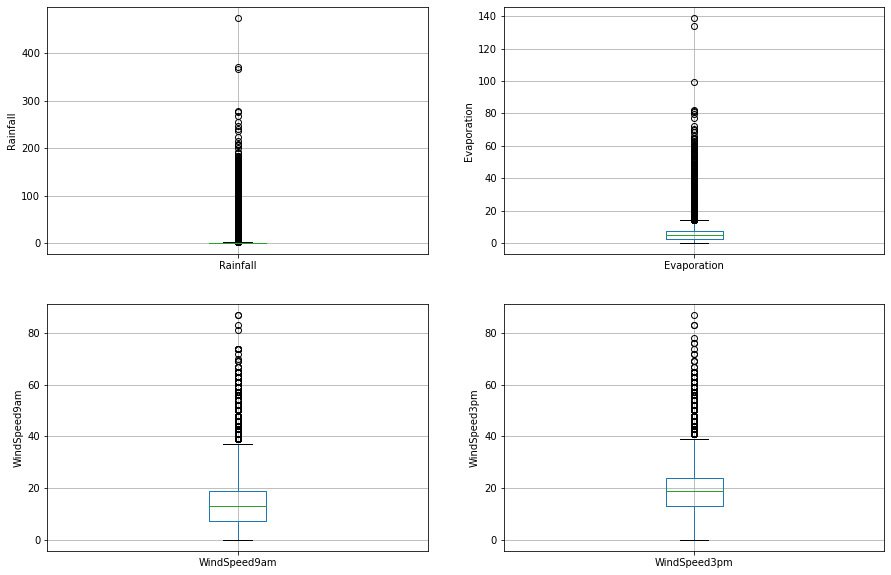

In [393]:
# draw boxplots to visualize outliers

plt.figure(figsize=(15,10))


plt.subplot(2, 2, 1)
fig = df.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')


plt.subplot(2, 2, 2)
fig = df.boxplot(column='Evaporation')
fig.set_title('')
fig.set_ylabel('Evaporation')


plt.subplot(2, 2, 3)
fig = df.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')


plt.subplot(2, 2, 4)
fig = df.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')

The above boxplots confirm that there are lot of outliers in these variables.

### Check the distribution of variables


- Plotting the histograms to check distributions to find out if they are normal or skewed. 

- If the variable follows normal distribution, Apply `Extreme Value Analysis` otherwise if they are skewed, use IQR (Interquantile range).

Text(0, 0.5, 'RainTomorrow')

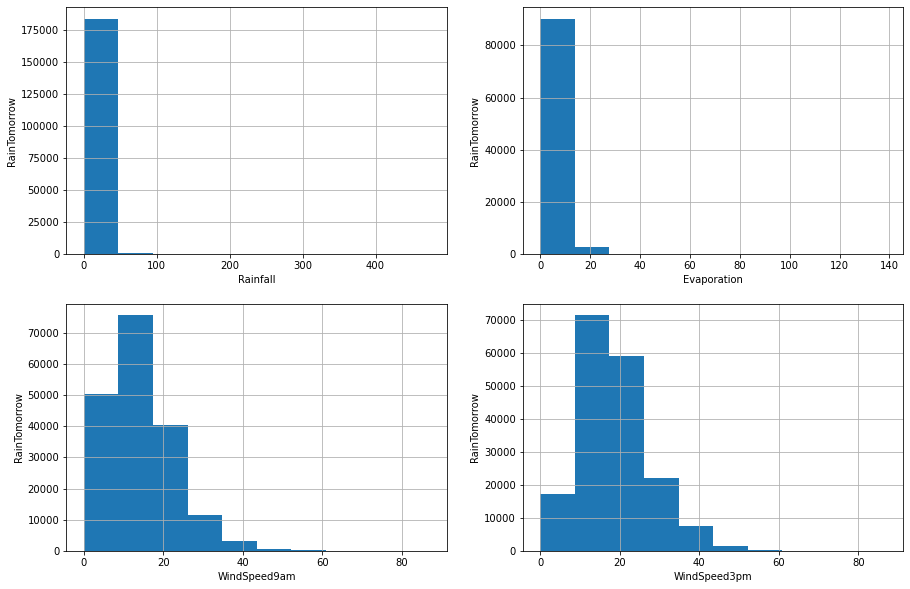

In [394]:
# plot histogram to check distribution

plt.figure(figsize=(15,10))


plt.subplot(2, 2, 1)
fig = df.Rainfall.hist(bins=10)
fig.set_xlabel('Rainfall')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 2)
fig = df.Evaporation.hist(bins=10)
fig.set_xlabel('Evaporation')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 3)
fig = df.WindSpeed9am.hist(bins=10)
fig.set_xlabel('WindSpeed9am')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 4)
fig = df.WindSpeed3pm.hist(bins=10)
fig.set_xlabel('WindSpeed3pm')
fig.set_ylabel('RainTomorrow')

All the four variables are skewed. Hence using interquantile range to find outliers.

In [395]:
# find outliers for Rainfall variable

IQR = df.Rainfall.quantile(0.75) - df.Rainfall.quantile(0.25)
Lower_fence = df.Rainfall.quantile(0.25) - (IQR * 3)
Upper_fence = df.Rainfall.quantile(0.75) + (IQR * 3)
print('Rainfall outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


Rainfall outliers are values < -1.7999999999999998 or > 2.4


In [396]:
# find outliers for Evaporation variable

IQR = df.Evaporation.quantile(0.75) - df.Evaporation.quantile(0.25)
Lower_fence = df.Evaporation.quantile(0.25) - (IQR * 3)
Upper_fence = df.Evaporation.quantile(0.75) + (IQR * 3)
print('Evaporation outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


Evaporation outliers are values < -11.0 or > 21.200000000000003


In [397]:
# find outliers for WindSpeed9am variable

IQR = df.WindSpeed9am.quantile(0.75) - df.WindSpeed9am.quantile(0.25)
Lower_fence = df.WindSpeed9am.quantile(0.25) - (IQR * 3)
Upper_fence = df.WindSpeed9am.quantile(0.75) + (IQR * 3)
print('WindSpeed9am outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


WindSpeed9am outliers are values < -29.0 or > 55.0


In [398]:
# find outliers for WindSpeed3pm variable

IQR = df.WindSpeed3pm.quantile(0.75) - df.WindSpeed3pm.quantile(0.25)
Lower_fence = df.WindSpeed3pm.quantile(0.25) - (IQR * 3)
Upper_fence = df.WindSpeed3pm.quantile(0.75) + (IQR * 3)
print('WindSpeed3pm outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))


WindSpeed3pm outliers are values < -20.0 or > 57.0


## 7. Multivariate Analysis <a class="anchor" id="7"></a>


- An important step in EDA is to discover patterns and relationships between variables in the dataset.

- Using heat map and pair plot to discover the patterns and relationships in the dataset.

In [399]:
correlation = df.corr()

### Heat Map <a class="anchor" id="7.1"></a>

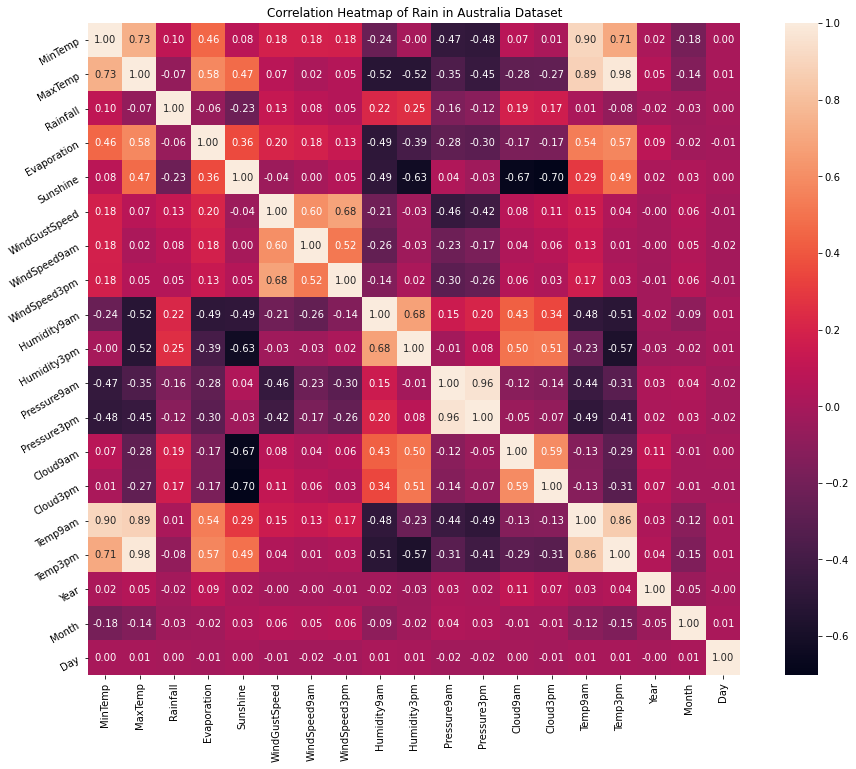

In [400]:
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

#### Interpretation

From the above correlation heat map, few variables clearly have strong positive correlation with each other!

No strong negative correlations spotted


### Pair Plot <a class="anchor" id="7.2"></a>

Extracting the variables which are highly positively correlated. 

In [401]:
num_var = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']

Pairplot to depict relationship between these variables.

In [402]:
# sns.pairplot(df[num_var], kind='scatter', diag_kind='hist', palette='Rainbow')
# plt.show()

#### Interpretation


- It's best to drop one of the features with Corr > 0.8 with each other

In [403]:
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191426,Uluru,23.0,33.9,0.0,NaN,NaN,ESE,43.0,ESE,SE,...,1010.6,NaN,NaN,25.6,32.3,No,No,2021,2,23
191427,Uluru,19.7,33.0,0.0,NaN,NaN,ESE,41.0,E,SSE,...,1008.5,NaN,NaN,24.9,31.7,No,No,2021,2,24
191428,Uluru,16.9,33.4,0.0,NaN,NaN,SSE,46.0,ENE,SSE,...,1007.2,NaN,NaN,25.0,31.8,No,No,2021,2,25
191429,Uluru,17.4,34.9,0.0,NaN,NaN,NE,41.0,ENE,N,...,1003.9,NaN,NaN,25.6,33.8,No,No,2021,2,26


In [404]:
df = df.drop(['Temp9am', 'Temp3pm','Pressure9am',], axis=1)

## 8. Declare feature vector and target variable <a class="anchor" id="8"></a>

In [405]:
categorical

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [406]:
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
RainToday         object
RainTomorrow      object
Year               int64
Month              int64
Day                int64
dtype: object

In [407]:
df[['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']] = df[['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']].astype(str)

In [408]:
#encoding
#from sklearn import preprocessing

label_encoder = LabelEncoder()
for i in categorical:
  df[i] = label_encoder.fit_transform(df[i])

In [409]:
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,Year,Month,Day
0,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,14,...,71.0,22.0,1007.1,8.0,NaN,0,0,2008,12,1
1,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,15,...,44.0,25.0,1007.8,NaN,NaN,0,0,2008,12,2
2,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,15,...,38.0,30.0,1008.7,NaN,2.0,0,0,2008,12,3
3,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,0,...,45.0,16.0,1012.8,NaN,NaN,0,0,2008,12,4
4,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,7,...,82.0,33.0,1006.0,7.0,8.0,0,0,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191426,41,23.0,33.9,0.0,NaN,NaN,2,43.0,2,9,...,31.0,20.0,1010.6,NaN,NaN,0,0,2021,2,23
191427,41,19.7,33.0,0.0,NaN,NaN,2,41.0,0,10,...,23.0,13.0,1008.5,NaN,NaN,0,0,2021,2,24
191428,41,16.9,33.4,0.0,NaN,NaN,10,46.0,1,10,...,17.0,11.0,1007.2,NaN,NaN,0,0,2021,2,25
191429,41,17.4,34.9,0.0,NaN,NaN,4,41.0,1,3,...,16.0,9.0,1003.9,NaN,NaN,0,0,2021,2,26


In [410]:
X = df.drop(['RainTomorrow'], axis=1)

y = df['RainTomorrow']

## 9. Split data into separate training and test set <a class="anchor" id="9"></a>

In [411]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = False, stratify = None)


In [412]:
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month,Day
0,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,14,...,24.0,71.0,22.0,1007.1,8.0,NaN,0,2008,12,1
1,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,15,...,22.0,44.0,25.0,1007.8,NaN,NaN,0,2008,12,2
2,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,15,...,26.0,38.0,30.0,1008.7,NaN,2.0,0,2008,12,3
3,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,0,...,9.0,45.0,16.0,1012.8,NaN,NaN,0,2008,12,4
4,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,7,...,20.0,82.0,33.0,1006.0,7.0,8.0,0,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152890,29,13.0,22.1,5.2,NaN,6.5,6,56.0,3,6,...,28.0,82.0,62.0,1012.0,NaN,8.0,1,2017,7,27
152891,29,14.5,18.5,13.6,NaN,NaN,14,65.0,14,13,...,35.0,78.0,77.0,1009.3,8.0,8.0,1,2017,7,28
152892,29,8.3,15.4,12.8,NaN,5.0,15,56.0,15,13,...,15.0,80.0,85.0,1018.1,8.0,8.0,1,2017,7,29
152893,29,6.3,17.7,14.4,NaN,6.5,12,30.0,2,7,...,11.0,71.0,46.0,1022.9,1.0,4.0,1,2017,7,30


In [413]:
X_test

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month,Day
152895,29,2.7,14.8,26.4,NaN,9.0,8,30.0,8,11,...,19.0,97.0,57.0,1029.5,NaN,5.0,1,2017,8,1
152896,29,2.0,15.7,0.0,NaN,9.7,9,24.0,9,11,...,9.0,88.0,59.0,1030.7,NaN,4.0,0,2017,8,2
152897,29,3.6,18.3,0.0,NaN,2.1,14,48.0,3,14,...,33.0,82.0,70.0,1020.1,8.0,8.0,0,2017,8,3
152898,29,7.8,15.0,1.8,NaN,1.0,15,30.0,4,6,...,13.0,83.0,70.0,1021.8,8.0,8.0,1,2017,8,4
152899,29,9.9,19.3,0.0,NaN,6.1,11,28.0,16,13,...,15.0,88.0,53.0,1020.3,4.0,1.0,0,2017,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191426,41,23.0,33.9,0.0,NaN,NaN,2,43.0,2,9,...,13.0,31.0,20.0,1010.6,NaN,NaN,0,2021,2,23
191427,41,19.7,33.0,0.0,NaN,NaN,2,41.0,0,10,...,17.0,23.0,13.0,1008.5,NaN,NaN,0,2021,2,24
191428,41,16.9,33.4,0.0,NaN,NaN,10,46.0,1,10,...,19.0,17.0,11.0,1007.2,NaN,NaN,0,2021,2,25
191429,41,17.4,34.9,0.0,NaN,NaN,4,41.0,1,3,...,6.0,16.0,9.0,1003.9,NaN,NaN,0,2021,2,26


In [414]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((147658, 21), (36915, 21))

## 10. Feature Engineering <a class="anchor" id="10"></a>



In [415]:
# check data types in X_train

X_train.dtypes

Location           int32
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir        int32
WindGustSpeed    float64
WindDir9am         int32
WindDir3pm         int32
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
RainToday          int32
Year               int64
Month              int64
Day                int64
dtype: object

In [416]:
# display categorical variables

categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

[]

In [417]:
# display numerical variables

numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'RainToday',
 'Year',
 'Month',
 'Day']

### Handling missing values in numerical variables <a class="anchor" id="10.1"></a>



In [418]:
# check missing values in numerical variables in X_train

X_train[numerical].isnull().sum()

Location             0
MinTemp            597
MaxTemp            471
Rainfall             0
Evaporation      75207
Sunshine         82604
WindGustDir          0
WindGustSpeed    12210
WindDir9am           0
WindDir3pm           0
WindSpeed9am      2369
WindSpeed3pm      5544
Humidity9am       1509
Humidity3pm       4451
Pressure3pm      13833
Cloud9am         60429
Cloud3pm         65730
RainToday            0
Year                 0
Month                0
Day                  0
dtype: int64

In [419]:
# check missing values in numerical variables in X_test

X_test[numerical].isnull().sum()

Location             0
MinTemp            122
MaxTemp            126
Rainfall             0
Evaporation      16252
Sunshine         17290
WindGustDir          0
WindGustSpeed      360
WindDir9am           0
WindDir3pm           0
WindSpeed9am        92
WindSpeed3pm       113
Humidity9am        264
Humidity3pm       1042
Pressure3pm       5916
Cloud9am         15069
Cloud3pm         15600
RainToday            0
Year                 0
Month                0
Day                  0
dtype: int64

In [420]:
# print percentage of missing values in the numerical variables in training set

for col in numerical:
    if X_train[col].isnull().mean()>0:
        print(col, round(X_train[col].isnull().mean(),4))

MinTemp 0.004
MaxTemp 0.0032
Evaporation 0.5093
Sunshine 0.5594
WindGustSpeed 0.0827
WindSpeed9am 0.016
WindSpeed3pm 0.0375
Humidity9am 0.0102
Humidity3pm 0.0301
Pressure3pm 0.0937
Cloud9am 0.4092
Cloud3pm 0.4452


## ####Assumption


Assuming that the data are missing completely at random (MCAR). A mean/median imputation or a random sample imputation can be used. Median imputation is preferred because it is robust to outliers.


Imputing missing values with the appropriate statistical measures of the data, in this case median. 

In [421]:
# impute missing values in X_train and X_test 

for df1 in [X_train, X_test]:
    for col in numerical:
        col_median=X_train[col].median()
        df1[col].fillna(col_median, inplace=True)           
      

### Handling missing values in categorical variables <a class="anchor" id="10.2"></a>

In [422]:
# print percentage of missing values in the categorical variables in training set

X_train[categorical].isnull().mean()

Series([], dtype: float64)

In [423]:
# print categorical variables with missing data

for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, (X_train[col].isnull().mean()))

In [424]:
# impute missing categorical variables with most frequent value

for df2 in [X_train, X_test]:
    df2['WindGustDir'].fillna(X_train['WindGustDir'].mode()[0], inplace=True)
    df2['WindDir9am'].fillna(X_train['WindDir9am'].mode()[0], inplace=True)
    df2['WindDir3pm'].fillna(X_train['WindDir3pm'].mode()[0], inplace=True)
    df2['RainToday'].fillna(X_train['RainToday'].mode()[0], inplace=True)

In [425]:
# check missing values in categorical variables in X_train

X_train[categorical].isnull().sum()

Series([], dtype: float64)

In [426]:
# check missing values in categorical variables in X_test

X_test[categorical].isnull().sum()

Series([], dtype: float64)

Final check for missing values in X_train and X_test.

In [427]:
# check missing values in X_train

X_train.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainToday        0
Year             0
Month            0
Day              0
dtype: int64

In [428]:
# check missing values in X_test

X_test.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainToday        0
Year             0
Month            0
Day              0
dtype: int64

### Handling outliers in numerical variables <a class="anchor" id="10.3"></a>


`Rainfall`, `Evaporation`, `WindSpeed9am` and `WindSpeed3pm` columns contain outliers. Using top-coding approach to cap maximum values and remove outliers from the above variables.

In [429]:
def max_value(df3, variable, top):
    return np.where(df3[variable]>top, top, df3[variable])

for df3 in [X_train, X_test]:
    df3['Rainfall'] = max_value(df3, 'Rainfall', 2.4)
    df3['Evaporation'] = max_value(df3, 'Evaporation', 21.2)
    df3['WindSpeed9am'] = max_value(df3, 'WindSpeed9am', 55)
    df3['WindSpeed3pm'] = max_value(df3, 'WindSpeed3pm', 57)

In [430]:
X_train.Rainfall.max(), X_test.Rainfall.max()

(2.4, 2.4)

In [431]:
X_train.Evaporation.max(), X_test.Evaporation.max()

(21.2, 21.2)

In [432]:
X_train.WindSpeed9am.max(), X_test.WindSpeed9am.max()

(55.0, 55.0)

In [433]:
X_train.WindSpeed3pm.max(), X_test.WindSpeed3pm.max()

(57.0, 57.0)

In [434]:
X_train[numerical].describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month,Day
count,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,...,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.0000,147658.000000
mean,23.665667,11.864005,22.788287,0.551530,4.943273,7.859303,8.557694,39.901631,8.315669,8.130172,...,18.859046,69.990905,52.228257,1015.845154,5.239452,4.837774,0.221051,2014.401075,6.5299,15.724302
std,14.556866,6.287478,6.913413,0.923513,2.619148,2.556008,4.982409,13.237579,4.880060,4.828747,...,8.907414,18.557555,20.441873,6.546118,2.297834,2.033224,0.414956,3.695127,3.4491,8.793853
min,0.000000,-8.700000,-4.100000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,979.000000,0.000000,0.000000,0.000000,2007.000000,1.0000,1.000000
25%,10.000000,7.400000,17.700000,0.000000,4.600000,8.200000,4.000000,31.000000,4.000000,4.000000,...,13.000000,58.000000,38.000000,1011.800000,4.000000,5.000000,0.000000,2011.000000,4.0000,8.000000
50%,24.000000,11.800000,22.400000,0.000000,4.600000,8.200000,9.000000,39.000000,8.000000,8.000000,...,19.000000,71.000000,53.000000,1015.800000,6.000000,5.000000,0.000000,2014.000000,7.0000,16.000000
75%,37.000000,16.600000,27.500000,0.600000,4.600000,8.200000,13.000000,46.000000,12.000000,12.000000,...,24.000000,84.000000,66.000000,1020.000000,7.000000,6.000000,0.000000,2018.000000,10.0000,23.000000
max,48.000000,33.900000,48.900000,2.400000,21.200000,14.500000,16.000000,135.000000,16.000000,16.000000,...,57.000000,100.000000,100.000000,1038.200000,9.000000,9.000000,1.000000,2021.000000,12.0000,31.000000


### Encoding categorical variables <a class="anchor" id="10.4"></a>

In [435]:
X_train.shape, X_test.shape

((147658, 21), (36915, 21))

In [436]:
X_train.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month,Day
0,2,13.4,22.9,0.6,4.6,8.2,13,44.0,13,14,...,24.0,71.0,22.0,1007.1,8.0,5.0,0,2008,12,1
1,2,7.4,25.1,0.0,4.6,8.2,14,44.0,6,15,...,22.0,44.0,25.0,1007.8,6.0,5.0,0,2008,12,2
2,2,12.9,25.7,0.0,4.6,8.2,15,46.0,13,15,...,26.0,38.0,30.0,1008.7,6.0,2.0,0,2008,12,3
3,2,9.2,28.0,0.0,4.6,8.2,4,24.0,9,0,...,9.0,45.0,16.0,1012.8,6.0,5.0,0,2008,12,4
4,2,17.5,32.3,1.0,4.6,8.2,13,41.0,1,7,...,20.0,82.0,33.0,1006.0,7.0,8.0,0,2008,12,5


## 11. Feature Scaling <a class="anchor" id="11"></a>

In [437]:
X_train.shape, X_test.shape

((147658, 21), (36915, 21))

In [438]:
cols = X_train.columns

In [439]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)


In [440]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [441]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [442]:
X_train.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month,Day
count,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,...,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000
mean,0.493035,0.482723,0.507326,0.229804,0.233173,0.542021,0.534856,0.284975,0.519729,0.508136,...,0.330860,0.699909,0.522283,0.622384,0.582161,0.537530,0.221051,0.528648,0.502718,0.490810
std,0.303268,0.147593,0.130442,0.384797,0.123545,0.176276,0.311401,0.099531,0.305004,0.301797,...,0.156270,0.185576,0.204419,0.110576,0.255315,0.225914,0.414956,0.263938,0.313555,0.293128
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.208333,0.377934,0.411321,0.000000,0.216981,0.565517,0.250000,0.218045,0.250000,0.250000,...,0.228070,0.580000,0.380000,0.554054,0.444444,0.555556,0.000000,0.285714,0.272727,0.233333
50%,0.500000,0.481221,0.500000,0.000000,0.216981,0.565517,0.562500,0.278195,0.500000,0.500000,...,0.333333,0.710000,0.530000,0.621622,0.666667,0.555556,0.000000,0.500000,0.545455,0.500000
75%,0.770833,0.593897,0.596226,0.250000,0.216981,0.565517,0.812500,0.330827,0.750000,0.750000,...,0.421053,0.840000,0.660000,0.692568,0.777778,0.666667,0.000000,0.785714,0.818182,0.733333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [443]:
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month,Day
0,0.041667,0.518779,0.509434,0.250000,0.216981,0.565517,0.8125,0.315789,0.8125,0.8750,...,0.421053,0.71,0.22,0.474662,0.888889,0.555556,0.0,0.071429,1.000000,0.000000
1,0.041667,0.377934,0.550943,0.000000,0.216981,0.565517,0.8750,0.315789,0.3750,0.9375,...,0.385965,0.44,0.25,0.486486,0.666667,0.555556,0.0,0.071429,1.000000,0.033333
2,0.041667,0.507042,0.562264,0.000000,0.216981,0.565517,0.9375,0.330827,0.8125,0.9375,...,0.456140,0.38,0.30,0.501689,0.666667,0.222222,0.0,0.071429,1.000000,0.066667
3,0.041667,0.420188,0.605660,0.000000,0.216981,0.565517,0.2500,0.165414,0.5625,0.0000,...,0.157895,0.45,0.16,0.570946,0.666667,0.555556,0.0,0.071429,1.000000,0.100000
4,0.041667,0.615023,0.686792,0.416667,0.216981,0.565517,0.8125,0.293233,0.0625,0.4375,...,0.350877,0.82,0.33,0.456081,0.777778,0.888889,0.0,0.071429,1.000000,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147653,0.604167,0.509390,0.494340,1.000000,0.216981,0.448276,0.3750,0.406015,0.1875,0.3750,...,0.491228,0.82,0.62,0.557432,0.666667,0.888889,1.0,0.714286,0.545455,0.866667
147654,0.604167,0.544601,0.426415,1.000000,0.216981,0.565517,0.8750,0.473684,0.8750,0.8125,...,0.614035,0.78,0.77,0.511824,0.888889,0.888889,1.0,0.714286,0.545455,0.900000
147655,0.604167,0.399061,0.367925,1.000000,0.216981,0.344828,0.9375,0.406015,0.9375,0.8125,...,0.263158,0.80,0.85,0.660473,0.888889,0.888889,1.0,0.714286,0.545455,0.933333
147656,0.604167,0.352113,0.411321,1.000000,0.216981,0.448276,0.7500,0.210526,0.1250,0.4375,...,0.192982,0.71,0.46,0.741554,0.111111,0.444444,1.0,0.714286,0.545455,0.966667


In [444]:
X_test

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month,Day
0,0.604167,0.267606,0.356604,1.00,0.216981,0.620690,0.5000,0.210526,0.5000,0.6875,...,0.333333,0.97,0.57,0.853041,0.666667,0.555556,1.0,0.714286,0.636364,0.000000
1,0.604167,0.251174,0.373585,0.00,0.216981,0.668966,0.5625,0.165414,0.5625,0.6875,...,0.157895,0.88,0.59,0.873311,0.666667,0.444444,0.0,0.714286,0.636364,0.033333
2,0.604167,0.288732,0.422642,0.00,0.216981,0.144828,0.8750,0.345865,0.1875,0.8750,...,0.578947,0.82,0.70,0.694257,0.888889,0.888889,0.0,0.714286,0.636364,0.066667
3,0.604167,0.387324,0.360377,0.75,0.216981,0.068966,0.9375,0.210526,0.2500,0.3750,...,0.228070,0.83,0.70,0.722973,0.888889,0.888889,1.0,0.714286,0.636364,0.100000
4,0.604167,0.436620,0.441509,0.00,0.216981,0.420690,0.6875,0.195489,1.0000,0.8125,...,0.263158,0.88,0.53,0.697635,0.444444,0.111111,0.0,0.714286,0.636364,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36910,0.854167,0.744131,0.716981,0.00,0.216981,0.565517,0.1250,0.308271,0.1250,0.5625,...,0.228070,0.31,0.20,0.533784,0.666667,0.555556,0.0,1.000000,0.090909,0.733333
36911,0.854167,0.666667,0.700000,0.00,0.216981,0.565517,0.1250,0.293233,0.0000,0.6250,...,0.298246,0.23,0.13,0.498311,0.666667,0.555556,0.0,1.000000,0.090909,0.766667
36912,0.854167,0.600939,0.707547,0.00,0.216981,0.565517,0.6250,0.330827,0.0625,0.6250,...,0.333333,0.17,0.11,0.476351,0.666667,0.555556,0.0,1.000000,0.090909,0.800000
36913,0.854167,0.612676,0.735849,0.00,0.216981,0.565517,0.2500,0.293233,0.0625,0.1875,...,0.105263,0.16,0.09,0.420608,0.666667,0.555556,0.0,1.000000,0.090909,0.833333


## 12. Model training <a class="anchor" id="12"></a>

In [445]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression


# initiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
logreg.fit(X_train, y_train)


LogisticRegression(random_state=0, solver='liblinear')

## 13. Predict results <a class="anchor" id="13"></a>

In [446]:
y_pred_test = logreg.predict(X_test)

y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

## 14. Check accuracy score <a class="anchor" id="14"></a>

In [447]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.8657


Here, **y_test** are the true class labels and **y_pred_test** are the predicted class labels in the test-set.

### Compare the train-set and test-set accuracy <a class="anchor" id="14.1"></a>

Comparing the train-set and test-set accuracy to check for overfitting.

In [448]:
y_pred_train = logreg.predict(X_train)

y_pred_train

array([0, 0, 0, ..., 1, 0, 1])

In [449]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8431


### Check for overfitting and underfitting <a class="anchor" id="14.2"></a>

In [450]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.8431
Test set score: 0.8657


The training-set accuracy score 0.8433 while the test-set accuracy to be 0.8656. These two values are quite comparable. Probability of overfitting is low. 


In Logistic Regression, we use default value of C = 1. It provides good performance with approximately 85% accuracy on both the training and the test set. But the model performance on both the training and test set are very comparable. It can be a case of underfitting. 

Tuning C to fit a more flexible model.

In [451]:
# fit the Logsitic Regression model with C=100

# instantiate the model
logreg100 = LogisticRegression(C=100, solver='liblinear', random_state=0)


# fit the model
logreg100.fit(X_train, y_train)

LogisticRegression(C=100, random_state=0, solver='liblinear')

In [452]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg100.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg100.score(X_test, y_test)))

Training set score: 0.8432
Test set score: 0.8659


C=100 results in no changes in accuracy. So, we can stop here.

### Compare model accuracy with null accuracy <a class="anchor" id="14.3"></a>


So, the model accuracy is 0.8656. But, we cannot say that our model is very good based on the above accuracy. We must compare it with the **null accuracy**. Null accuracy is the accuracy that could be achieved by always predicting the most frequent class.

So, we should first check the class distribution in the test set. 

In [453]:
# check class distribution in test set

y_test.value_counts()

0    29776
1     7139
Name: RainTomorrow, dtype: int64

We can see that the occurences of most frequent class is 29776. So, we can calculate null accuracy by dividing 29008 by total number of occurences.

In [454]:
# check null accuracy score

null_accuracy = (29008/(29008+7907))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.7858


#### Interpretation

We can see that our model accuracy score is 0.8656 but null accuracy score is 0.7858. So, we can conclude that our Logistic Regression model is doing fine in predicting the class labels.

#### Interpretation

Now, based on the above analysis we can conclude that our classification model accuracy is very good. Our model is doing a very good job in terms of predicting the class labels.


But, it does not give the underlying distribution of values. Also, it does not tell anything about the type of errors our classifer is making. 


Using `Confusion matrix`

## 15. Confusion matrix <a class="anchor" id="15"></a>


A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.


Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:-


**True Positives (TP)** – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.


**True Negatives (TN)** – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.


**False Positives (FP)** – False Positives occur when we predict an observation belongs to a    certain class but the observation actually does not belong to that class. This type of error is called **Type I error.**



**False Negatives (FN)** – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called **Type II error.**



These four outcomes are summarized in a confusion matrix given below.


In [455]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[28449  1327]
 [ 3629  3510]]

True Positives(TP) =  28449

True Negatives(TN) =  3510

False Positives(FP) =  1327

False Negatives(FN) =  3629


<AxesSubplot:>

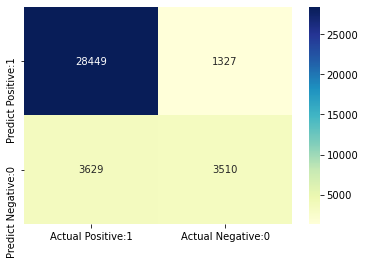

In [456]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## 16. Classification Metrices <a class="anchor" id="16"></a>

### Classification Report <a class="anchor" id="16.1"></a>


**Classification report** is another way to evaluate the classification model performance. It displays the  **precision**, **recall**, **f1** and **support** scores for the model.

In [457]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     29776
           1       0.73      0.49      0.59      7139

    accuracy                           0.87     36915
   macro avg       0.81      0.72      0.75     36915
weighted avg       0.86      0.87      0.86     36915



### Classification Accuracy <a class="anchor" id="16.2"></a>

In [458]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [459]:
# print classification accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))


Classification accuracy : 0.8657


### Classification Error <a class="anchor" id="16.3"></a>

In [460]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))


Classification error : 0.1343


### Precision <a class="anchor" id="16.4"></a>


**Precision** can be defined as the percentage of correctly predicted positive outcomes out of all the predicted positive outcomes. It can be given as the ratio of true positives (TP) to the sum of true and false positives (TP + FP). 


So, **Precision** identifies the proportion of correctly predicted positive outcome. It is more concerned with the positive class than the negative class.



Mathematically, precision can be defined as the ratio of `TP to (TP + FP).`




In [461]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))


Precision : 0.9554


### Recall <a class="anchor" id="16.5"></a>


Recall can be defined as the percentage of correctly predicted positive outcomes out of all the actual positive outcomes.
It can be given as the ratio of true positives (TP) to the sum of true positives and false negatives (TP + FN). **Recall** is also called **Sensitivity**.


**Recall** identifies the proportion of correctly predicted actual positives.


Mathematically, recall can be given as the ratio of `TP to (TP + FN).`





In [462]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.8869


### True Positive Rate <a class="anchor" id="16.6"></a>


**True Positive Rate** is synonymous with **Recall**.


In [463]:
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.8869


### False Positive Rate <a class="anchor" id="16.7"></a>

In [464]:
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.2743


### Specificity <a class="anchor" id="16.8"></a>

In [465]:
specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.7257


### f1-score <a class="anchor" id="16.9"></a>


**f1-score** is the weighted harmonic mean of precision and recall. The best possible **f1-score** would be 1.0 and the worst 
would be 0.0.  **f1-score** is the harmonic mean of precision and recall. So, **f1-score** is always lower than accuracy measures as they embed precision and recall into their computation. The weighted average of `f1-score` should be used to 
compare classifier models, not global accuracy.



## Model evaluation and improvement

k-fold cross validation` and `hyperparameter optimization using GridSearchCV`.

## 20. k-Fold Cross Validation <a class="anchor" id="20"></a>

In [466]:
# Applying 5-Fold Cross Validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, X_train, y_train, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.83753217 0.83336719 0.8240214  0.84883682 0.84697437]


In [467]:
# compute Average cross-validation score

print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.8381


Our, original model score is found to be 0.8656. The average cross-validation score is 0.8513. So, we can conclude that cross-validation does not result in performance improvement.

## 21. Hyperparameter Optimization using GridSearch CV <a class="anchor" id="21"></a>

In [468]:
from sklearn.model_selection import GridSearchCV


parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]



grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [469]:
# examine the best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.8381


Parameters that give the best results : 

 {'penalty': 'l1'}


Estimator that was chosen by the search : 

 LogisticRegression(penalty='l1', random_state=0, solver='liblinear')


In [470]:
# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV score on test set: 0.8658


### Comments


- Our original model test accuracy is 0.8656 while GridSearch CV accuracy is 0.8657.


- We can see that GridSearch CV does not improve the performance much for this particular model.

## Random Forest Classifier

In [471]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report # To get models info.

Randfor = RandomForestClassifier(n_estimators=10)
Randfor.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [472]:
y_pred_test = Randfor.predict(X_test)
y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [473]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.8591


In [474]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     29776
           1       0.72      0.45      0.55      7139

    accuracy                           0.86     36915
   macro avg       0.80      0.70      0.73     36915
weighted avg       0.85      0.86      0.85     36915



## Decision Trees


In [475]:
from sklearn.tree import DecisionTreeClassifier
Dectree = DecisionTreeClassifier()
Dectree.fit(X_train, y_train)

DecisionTreeClassifier()

In [476]:
y_pred_test = Dectree.predict(X_test)
y_pred_test

array([0, 0, 1, ..., 0, 0, 0])

In [477]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.7932


In [478]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     29776
           1       0.47      0.51      0.49      7139

    accuracy                           0.79     36915
   macro avg       0.67      0.69      0.68     36915
weighted avg       0.80      0.79      0.80     36915



## 22. Dense Neural Network

In [479]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_pred_train.shape, y_pred_test.shape

((147658, 21), (36915, 21), (147658,), (36915,), (147658,), (36915,))

In [480]:
X_train_old=X_train.copy()
X_test_old=X_test.copy()
y_train_old=y_train.copy()
y_test_old=y_test.copy()

#### Formatting Date.

Encoding dates appropriately, the months and days format in a cyclic continuous feature. As, date and time are inherently cyclical. To let the ANN model know that a feature is cyclical, splitting them into periodic subsections such as years, months and days and creating two new features, deriving a sine transform and cosine transform of the each subsection feature. Thus we obtain Month_sin, Month_cos, Day_sin, Day_cos.

In [481]:
# Below is the fucntion to encode datetime into cyclic parameters. 
# We prefer the months and days in a cyclic continuous feature as we plan to use this data in a neural network  
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data


df = encode(df, 'Month', 12)

df = encode(df,  'Day', 31)

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,RainToday,RainTomorrow,Year,Month,Day,Month_sin,Month_cos,Day_sin,Day_cos
0,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,14,...,NaN,0,0,2008,12,1,-2.449294e-16,1.0,0.201299,0.979530
1,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,15,...,NaN,0,0,2008,12,2,-2.449294e-16,1.0,0.394356,0.918958
2,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,15,...,2.0,0,0,2008,12,3,-2.449294e-16,1.0,0.571268,0.820763
3,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,0,...,NaN,0,0,2008,12,4,-2.449294e-16,1.0,0.724793,0.688967
4,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,7,...,8.0,0,0,2008,12,5,-2.449294e-16,1.0,0.848644,0.528964


Text(0.5, 0, 'Sine Encoded Months')

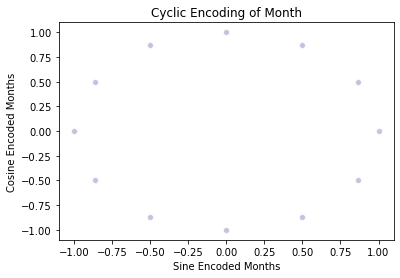

In [482]:
# # Plotting Encoded Months
cyclic_month = sns.scatterplot(x="Month_sin",y="Month_cos",data=df, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

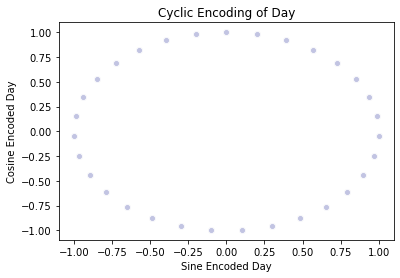

In [483]:
# # Plotting Encoded days
cyclic_day = sns.scatterplot(x='Day_sin',y='Day_cos',data=df, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [484]:
# Removing Extra Features before splitting
X = df.drop(["RainTomorrow", 'Day', 'Month'], axis=1)
#X = df.drop(["RainTomorrow"], axis=1)
y = df["RainTomorrow"]

In [485]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = False, stratify = None)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((147658, 23), (36915, 23), (147658,), (36915,))

In [486]:
# impute missing values in X_train and X_test with respective column median in X_train

for df1 in [X_train, X_test]:
    for col in X_train.columns:
        col_median=X_train[col].median()
        df1[col].fillna(col_median, inplace=True)           
      

In [487]:
X_train.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainToday        0
Year             0
Month_sin        0
Month_cos        0
Day_sin          0
Day_cos          0
dtype: int64

In [488]:
X_train.shape, X_test.shape

((147658, 23), (36915, 23))

In [489]:
cols = X_train.columns

In [490]:
#Set up a MinMax scaler for the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)


In [491]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [492]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [493]:
X_train.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,Year,Month_sin,Month_cos,Day_sin,Day_cos
count,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,...,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000,147658.000000
mean,0.493035,0.482723,0.507326,0.004858,0.037209,0.542021,0.534856,0.284975,0.519729,0.508136,...,0.522283,0.622384,0.582161,0.537530,0.221051,0.528648,0.491376,0.499620,0.500759,0.488837
std,0.303268,0.147593,0.130442,0.017954,0.022553,0.176276,0.311401,0.099531,0.305004,0.301797,...,0.204419,0.110576,0.255315,0.225914,0.414956,0.263938,0.351773,0.355222,0.356966,0.351338
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.208333,0.377934,0.411321,0.000000,0.034354,0.565517,0.250000,0.218045,0.250000,0.250000,...,0.380000,0.554054,0.444444,0.555556,0.000000,0.285714,0.066987,0.066987,0.137138,0.118359
50%,0.500000,0.481221,0.500000,0.000000,0.034354,0.565517,0.562500,0.278195,0.500000,0.500000,...,0.530000,0.621622,0.666667,0.555556,0.000000,0.500000,0.500000,0.500000,0.500000,0.473324
75%,0.770833,0.593897,0.596226,0.001266,0.034354,0.565517,0.812500,0.330827,0.750000,0.750000,...,0.660000,0.692568,0.777778,0.666667,0.000000,0.785714,0.750000,0.933013,0.862862,0.844083
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [494]:
#Dense Neural Network with 5 Layers and additional dropout layers to avoid overfitting

#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 64, kernel_initializer = 'uniform', input_dim = X_train.shape[1]))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
3692/3692 [==============================] - 3s 889us/step - loss: 0.4347 - accuracy: 0.7942 - val_loss: 0.3632 - val_accuracy: 0.8519
Epoch 2/150
3692/3692 [==============================] - 3s 857us/step - loss: 0.4085 - accuracy: 0.8344 - val_loss: 0.3562 - val_accuracy: 0.8519
Epoch 3/150
3692/3692 [==============================] - 3s 855us/step - loss: 0.4067 - accuracy: 0.8344 - val_loss: 0.3529 - val_accuracy: 0.8563
Epoch 4/150
3692/3692 [==============================] - 3s 855us/step - loss: 0.4054 - accuracy: 0.8341 - val_loss: 0.3578 - val_accuracy: 0.8541
Epoch 5/150
3692/3692 [==============================] - 3s 874us/step - loss: 0.4045 - accuracy: 0.8352 - val_loss: 0.3645 - val_accuracy: 0.8496
Epoch 6/150
3692/3692 [==============================] - 3s 860us/step - loss: 0.4035 - accuracy: 0.8348 - val_loss: 0.3682 - val_accuracy: 0.8513
Epoch 7/150
3692/3692 [==============================] - 3s 833us/step - loss: 0.4044 - accuracy: 0.8349 - val_loss: 0

In [495]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)



<AxesSubplot:>

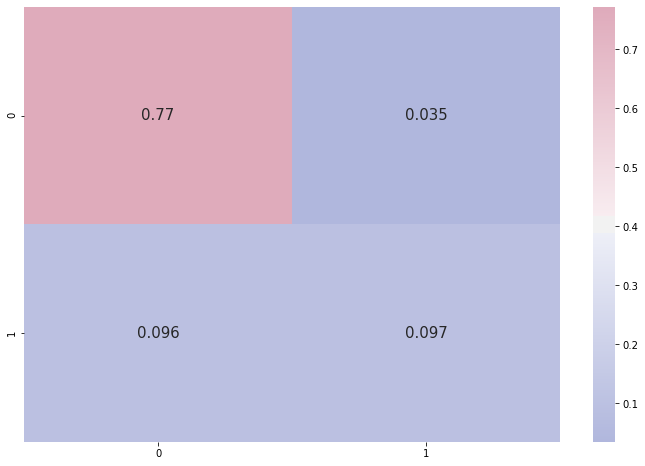

In [496]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})


In [497]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     29776
           1       0.74      0.50      0.60      7139

    accuracy                           0.87     36915
   macro avg       0.81      0.73      0.76     36915
weighted avg       0.86      0.87      0.86     36915



In [498]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8690


## 23. Results and Conclusion <a class="anchor" id="22"></a>

Since the sensitivity to wrong predictions of rainfall requires a specific use case, we can relax the model comparisons to just Accuracy here and not other measures like Precison and Recall. The other measures are more suitable when a particular FN or a FP is highly undesired in the use case.

Accuracy of models:

*   Logistic Regression : 0.8656
-   Decision Trees      : 0.7931
-   Randon Forests      : 0.8580
*   Neural Nets         : 0.8690

We pick Neural Networks as the best among all and we can further train the entire data to fit this model.
